In [2]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
# read dataframe
df = pd.read_csv("stage3.csv")

In [5]:
# assess missingness in data
rows_with_missingness = df.isna().any(axis=1).sum()
cols_with_missingness =  df.isna().any().sum()
col_missingness = df.isna().sum()

In [6]:
print('# rows with missingness:', rows_with_missingness)
print('# columns with missingness:', cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 238618
# columns with missingness: 21

columns with missingness:
incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       22390

In [7]:
# quantify numerical variables
max_n_killed = df['n_killed'].max()
min_n_killed = df['n_killed'].min()
max_n_injured = df['n_injured'].max()
min_n_injured = df['n_injured'].min()

In [8]:
print(max_n_killed,min_n_killed)

50 0


In [9]:
print(max_n_injured, min_n_injured)

53 0


In [10]:
df.shape

(239677, 29)

In [11]:
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


# Find out what percentage of Subject-Suspect are not equal to one

In [38]:
def count_arrested(s):
    if isinstance(s, str):
        return s.count('Subject-Suspect')
    else:
        return 2


# Apply the function to the 'participant_type' column
df['arrested_count'] = df['participant_type'].apply(count_arrested)
# Calculate the fraction of rows where 'arrested_count' is not equal to one
fraction_not_one_arrest = (df['arrested_count'] != 1).mean()
print(fraction_not_one_arrest)

0.0


# Drop all rows with none 1 Subject-Suspect

In [39]:
df = df[df['arrested_count'] == 1]
df.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1
286,92218,2014-01-01,Georgia,Bibb County,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,142.0,26.0,1,35.0,24.0,Male,30-40,1,2014,1
287,104905,2014-01-01,Virginia,Prince William County,0,1,1.0,NaN,NaN,Shot - Wounded/Injured,...,50.0,29.0,1,25.0,31.0,Male,20-30,1,2014,1
289,94154,2014-01-01,Virginia,Hampton,0,0,3.0,NaN,NaN,Armed robbery with injury/death and/or evidenc...,...,92.0,2.0,1,19.0,19.0,Male,10-20,1,2014,1


# Get the Suspect age and create a new column with suspect age  

In [14]:
def extract_subject_suspect_age(participant_type, participant_age):
    if isinstance(participant_type, str) and isinstance(participant_age, str):
        # Split the strings into lists
        types = participant_type.split("||")
        ages = participant_age.split("||")

        # Dictionary to hold index and type
        type_dict = {}
        for t in types:
            parts = t.split("::")
            if len(parts) == 2:
                index, type = parts
                type_dict[index] = type

        # Find the index of 'Subject-Suspect'
        suspect_index = None
        for index, type in type_dict.items():
            if type == "Subject-Suspect":
                suspect_index = index
                break

        # Find the corresponding age
        if suspect_index is not None:
            for age in ages:
                age_parts = age.split("::")
                if len(age_parts) == 2 and age_parts[0] == suspect_index:
                    return int(age_parts[1])
    
    return None  # Return None if inputs are not strings or no 'Subject-Suspect' found

# Apply the function to create the new column
df['Subject-Suspect_age'] = df.apply(lambda x: extract_subject_suspect_age(x['participant_type'], x['participant_age']), axis=1)

# Remove rows where 'Subject-Suspect_age' is NaN
df = df.dropna(subset=['Subject-Suspect_age'])
df.shape



(66772, 31)

# Get the victims average age

In [15]:
def extract_victim_average_age(participant_type, participant_age):
    if isinstance(participant_type, str) and isinstance(participant_age, str):
        # Split the strings into lists
        types = participant_type.split("||")
        ages = participant_age.split("||")

        # Dictionary to hold index and type
        type_dict = {}
        for t in types:
            parts = t.split("::")
            if len(parts) == 2:
                index, type = parts
                type_dict[index] = type

        # List to hold the ages of 'Victim'
        victim_ages = []
        for index, type in type_dict.items():
            if type == "Victim":
                for age in ages:
                    age_parts = age.split("::")
                    if len(age_parts) == 2 and age_parts[0] == index:
                        try:
                            victim_ages.append(int(age_parts[1]))
                        except ValueError:
                            # Handle cases where age is not a number
                            continue

        # Calculate the average age of victims if any victims are found
        if victim_ages:
            return sum(victim_ages) / len(victim_ages)
    
    return None  # Return None if inputs are not strings or no 'Victim' found

# Apply the function to create the new column
df['Victim_average_age'] = df.apply(lambda x: extract_victim_average_age(x['participant_type'], x['participant_age']), axis=1)

df.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'arrested_count', 'Subject-Suspect_age',
       'Victim_average_age'],
      dtype='object')

# Get the Suspect age

In [16]:
def extract_subject_suspect_gender(participant_type, participant_gender):
    if isinstance(participant_type, str) and isinstance(participant_gender, str):
        # Split the strings into lists
        types = participant_type.split("||")
        genders = participant_gender.split("||")

        # Dictionary to hold index and type
        type_dict = {}
        for t in types:
            parts = t.split("::")
            if len(parts) == 2:
                index, type = parts
                type_dict[index] = type

        # Find the index of 'Subject-Suspect'
        suspect_index = None
        for index, type in type_dict.items():
            if type == "Subject-Suspect":
                suspect_index = index
                break

        # Find the corresponding gender
        if suspect_index is not None:
            for gender in genders:
                gender_parts = gender.split("::")
                if len(gender_parts) == 2 and gender_parts[0] == suspect_index:
                    return gender_parts[1]
    
    return None  # Return None if inputs are not strings or no 'Subject-Suspect' found

# Apply the function to create the new column
df['Subject-Suspect_gender'] = df.apply(lambda x: extract_subject_suspect_gender(x['participant_type'], x['participant_gender']), axis=1)
df = df.dropna(subset=['Subject-Suspect_gender'])
df.shape




(65887, 33)

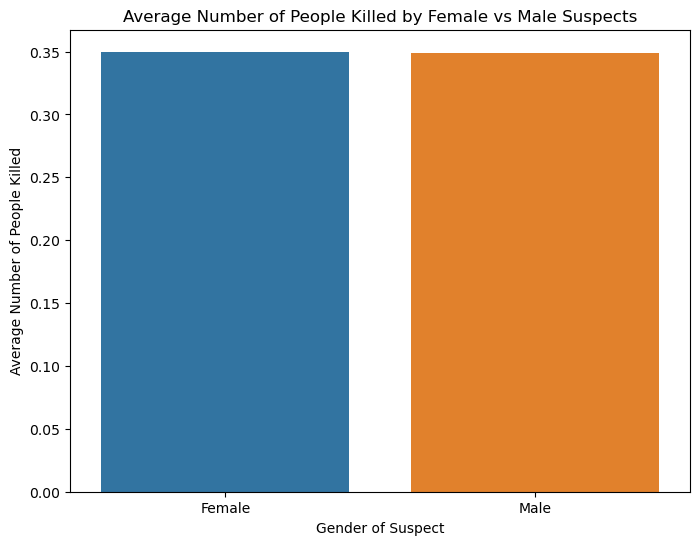

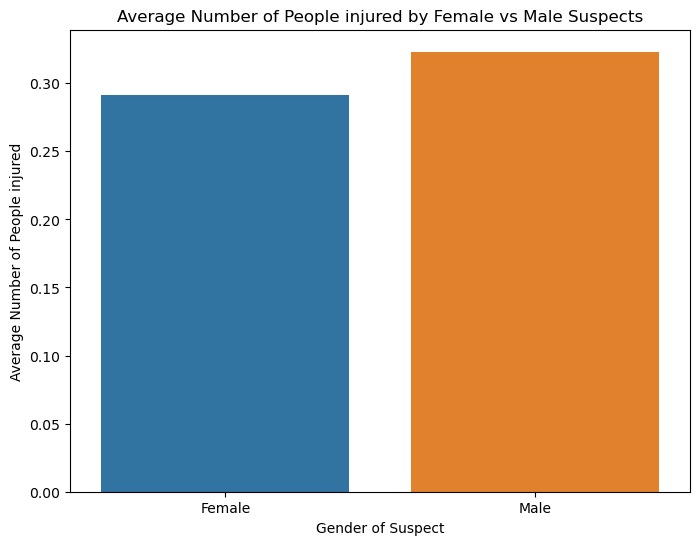

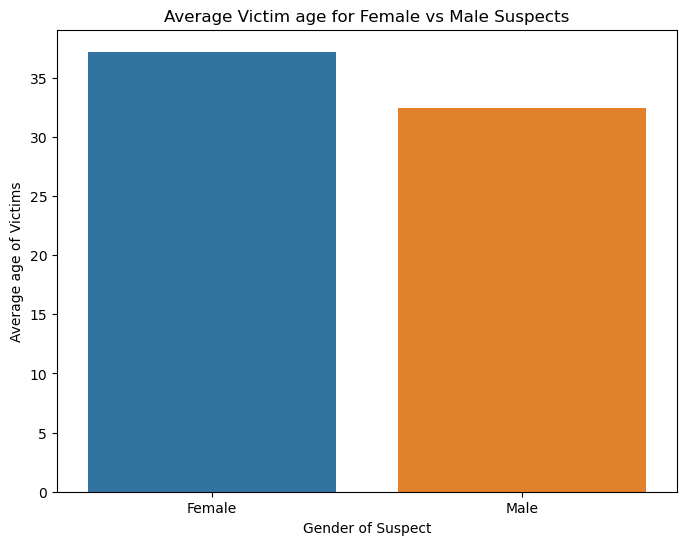

In [17]:
# Grouping by gender and calculating average 'n_killed'
gender_killed_avg = df.groupby('Subject-Suspect_gender')['n_killed'].mean()

# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_killed_avg.index, y=gender_killed_avg.values)
plt.title('Average Number of People Killed by Female vs Male Suspects')
plt.xlabel('Gender of Suspect')
plt.ylabel('Average Number of People Killed')
plt.show()


# Grouping by gender and calculating average 'n_injured'
gender_killed_avg = df.groupby('Subject-Suspect_gender')['n_injured'].mean()

# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_killed_avg.index, y=gender_killed_avg.values)
plt.title('Average Number of People injured by Female vs Male Suspects')
plt.xlabel('Gender of Suspect')
plt.ylabel('Average Number of People injured')
plt.show()

# Grouping by gender and calculating average 'n_injured'
gender_killed_avg = df.groupby('Subject-Suspect_gender')['Victim_average_age'].mean()

# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_killed_avg.index, y=gender_killed_avg.values)
plt.title('Average Victim age for Female vs Male Suspects')
plt.xlabel('Gender of Suspect')
plt.ylabel('Average age of Victims')
plt.show()


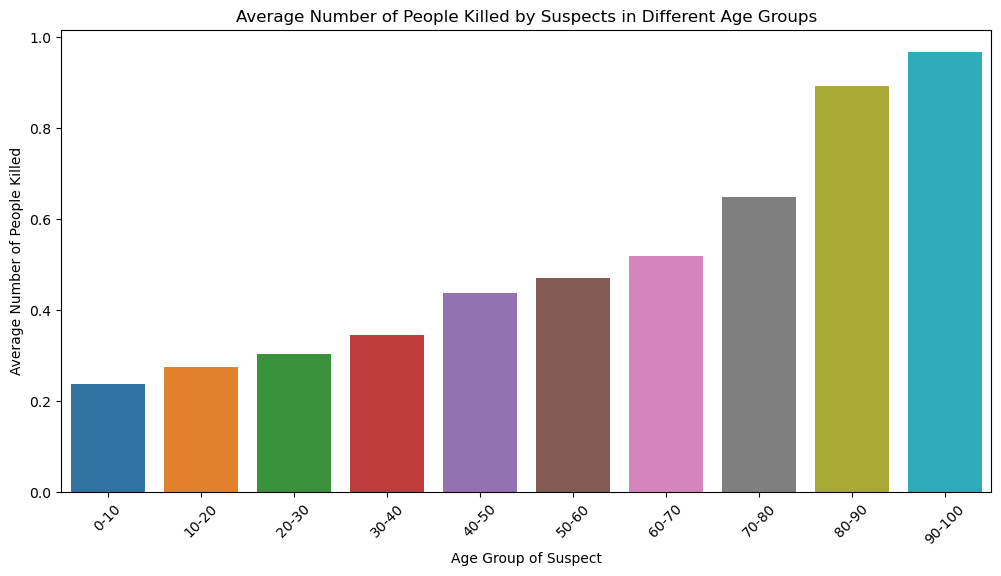

In [18]:
bins = np.arange(0, 101, 10)  # Ends at 100
labels = [f'{i}-{i+10}' for i in range(0, 90, 10)] + ['90-100']

# Filter out unrealistic ages if necessary
df = df[df['Subject-Suspect_age'] <= 100]

# Create Age Group
df['Age_Group_in_10s'] = pd.cut(df['Subject-Suspect_age'], bins=bins, labels=labels, right=False)


# Group by age group and calculate average 'n_killed'
age_group_killed_avg = df.groupby('Age_Group_in_10s')['n_killed'].mean()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=age_group_killed_avg.index, y=age_group_killed_avg.values)
plt.title('Average Number of People Killed by Suspects in Different Age Groups')
plt.xlabel('Age Group of Suspect')
plt.ylabel('Average Number of People Killed')
plt.xticks(rotation=45)
plt.show()

Age_Group_in_10s
0-10      0.565421
10-20     0.365809
20-30     0.350910
30-40     0.287391
40-50     0.278197
50-60     0.275147
60-70     0.282609
70-80     0.280000
80-90     0.218884
90-100    0.233333
Name: n_injured, dtype: float64


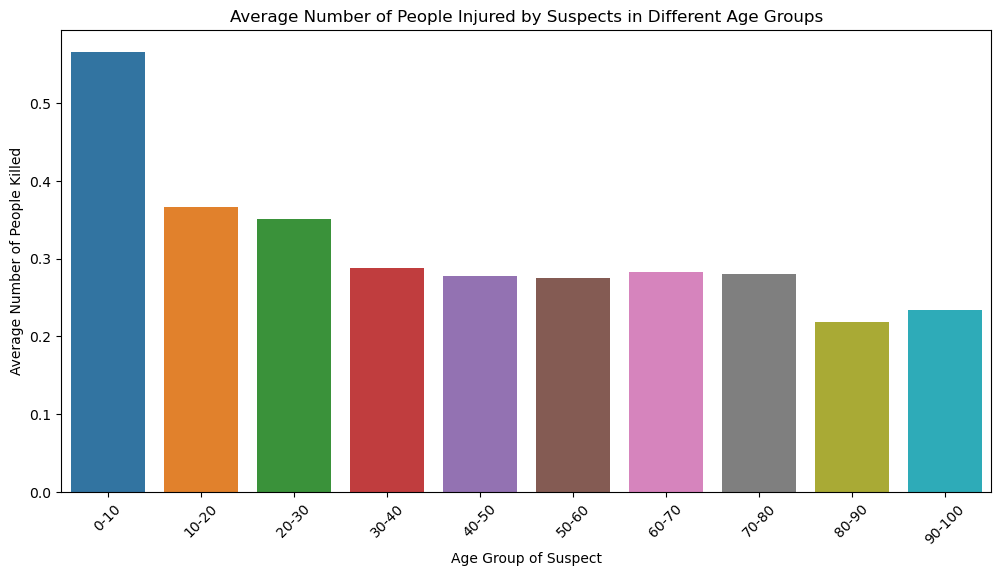

In [19]:
# Grouping by age group and calculating average 'n_killed'
age_group_killed_avg = df.groupby('Age_Group_in_10s')['n_injured'].mean()
print(age_group_killed_avg)

# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=age_group_killed_avg.index, y=age_group_killed_avg.values)
plt.title('Average Number of People Injured by Suspects in Different Age Groups')
plt.xlabel('Age Group of Suspect')
plt.ylabel('Average Number of People Killed')
plt.xticks(rotation=45)
plt.show()

State Vs Average Age of perpetrators 

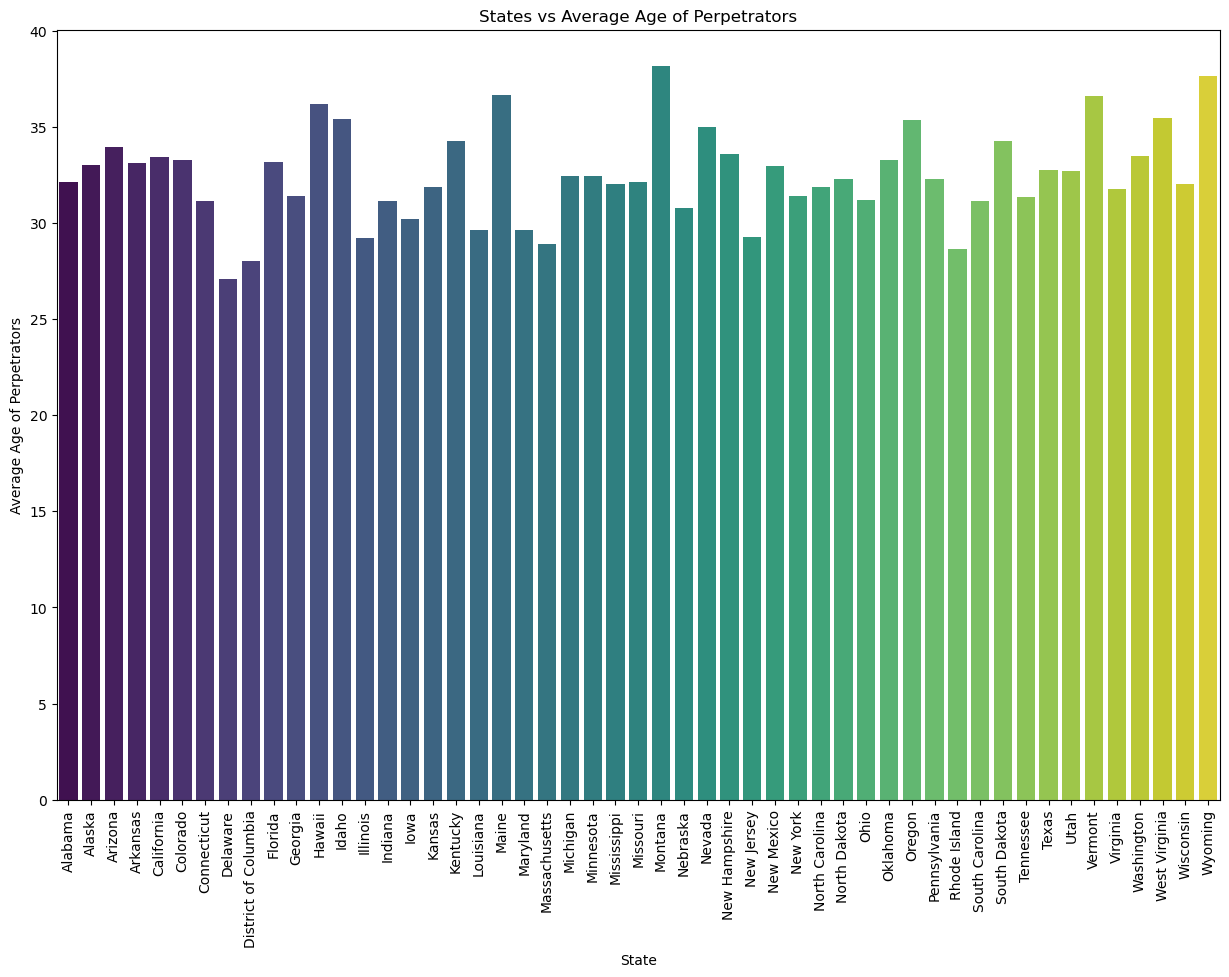

In [20]:
average_ages = df.groupby('state')['Subject-Suspect_age'].mean().reset_index()

plt.figure(figsize=(15, 10))  # Adjust the size of the plot as needed
sns.barplot(x='state', y='Subject-Suspect_age', data=average_ages, palette='viridis')
plt.xlabel('State')
plt.ylabel('Average Age of Perpetrators')
plt.title('States vs Average Age of Perpetrators')
plt.xticks(rotation=90)  # Rotates the state names for better readability
plt.show()

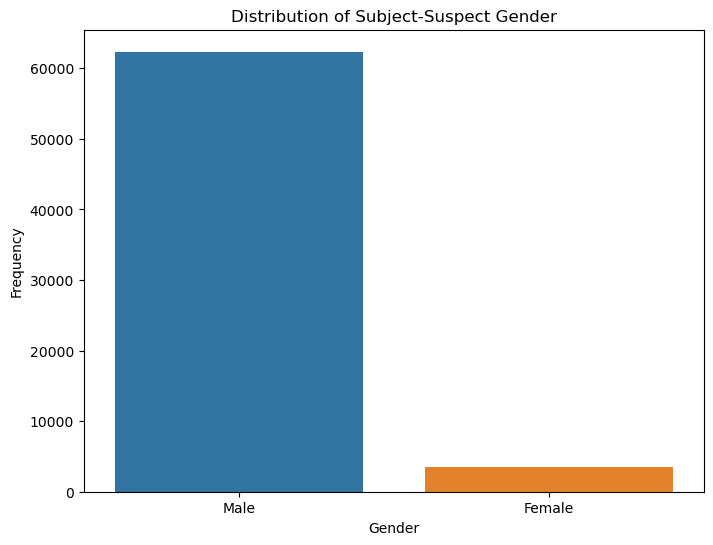

In [21]:
# Gender
# Count Plot
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Subject-Suspect_gender'])
plt.title('Distribution of Subject-Suspect Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

Victim age vs Suspect age graph

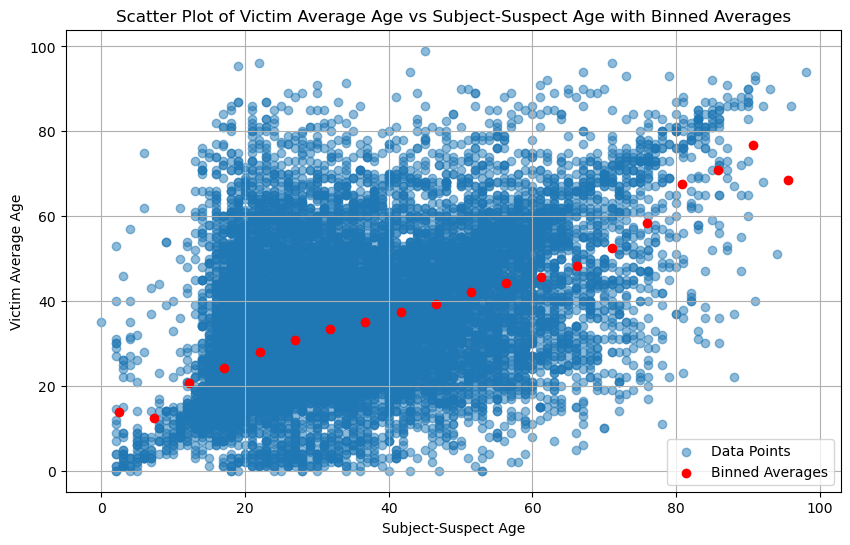

In [22]:
# Scatter plot
# Define bin edges for Subject-Suspect_age
# Define bin edges for Subject-Suspect_age
num_bins = 20
bin_edges = np.linspace(df['Subject-Suspect_age'].min(), df['Subject-Suspect_age'].max(), num=num_bins + 1) # Plus one for edge

# Calculate the average Victim_average_age for each bin
binned_averages = [df[(df['Subject-Suspect_age'] >= bin_edges[i]) & (df['Subject-Suspect_age'] < bin_edges[i+1])]['Victim_average_age'].mean() for i in range(num_bins)]

# Prepare bin_centers considering the actual range of data in each bin
bin_centers = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(num_bins)]

# Remove NaN values from binned_averages and corresponding centers (if any)
bin_centers = [bin_centers[i] for i in range(num_bins) if not np.isnan(binned_averages[i])]
binned_averages = [avg for avg in binned_averages if not np.isnan(avg)]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Subject-Suspect_age'], df['Victim_average_age'], alpha=0.5, label='Data Points')
plt.scatter(bin_centers, binned_averages, color='red', label='Binned Averages') # Plotting the averages
plt.title('Scatter Plot of Victim Average Age vs Subject-Suspect Age with Binned Averages')
plt.xlabel('Subject-Suspect Age')
plt.ylabel('Victim Average Age')
plt.legend()
plt.grid(True)
plt.show()

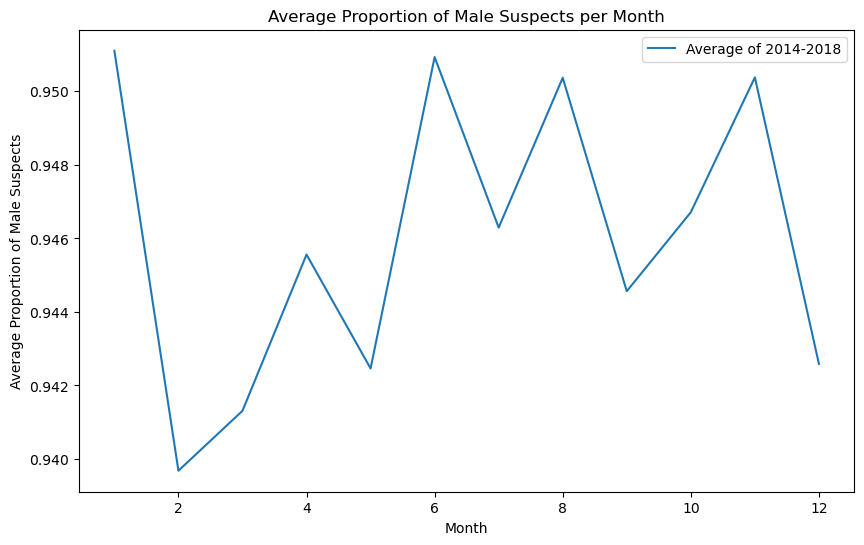

In [23]:
# Exclude the year 2013 and convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year != 2013]


# Convert the 'Subject-Suspect_gender' column to a binary (1 for Male, 0 for Female)
df['Subject-Suspect_gender_binary'] = df['Subject-Suspect_gender'].map({'Male': 1, 'Female': 0})

# Extract year and month from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by year, month, and gender, then count
count_gender = df.groupby(['year', 'month', 'Subject-Suspect_gender']).size().reset_index(name='count')

# Pivot the table to have separate columns for male and female counts
pivot_table = count_gender.pivot_table(index=['year', 'month'], columns='Subject-Suspect_gender', values='count', fill_value=0)

# Calculate the proportion of male suspects
pivot_table['proportion_male'] = pivot_table['Male'] / (pivot_table['Male'] + pivot_table['Female'])

# Calculate the average proportion of male suspects per month across all years
average_proportion = pivot_table.groupby('month')['proportion_male'].mean()

# Plotting the average proportion of male suspects by month
plt.figure(figsize=(10, 6))
plt.plot(average_proportion.index, average_proportion, label='Average of 2014-2018')

plt.xlabel('Month')
plt.ylabel('Average Proportion of Male Suspects')
plt.title('Average Proportion of Male Suspects per Month')
plt.legend()
plt.show()

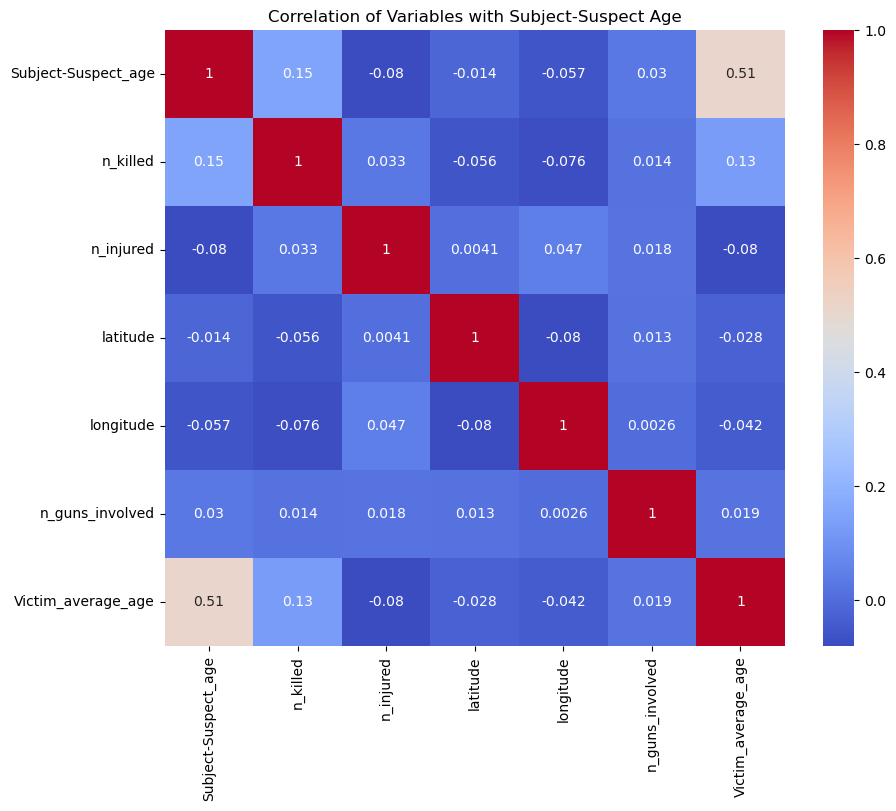

In [24]:

# Select relevant columns for correlation analysis
columns_for_correlation = ['Subject-Suspect_age', 'n_killed', 'n_injured', 'latitude', 'longitude', 'n_guns_involved','Victim_average_age']

# Filter out rows with missing values in these columns
df_filtered = df[columns_for_correlation].dropna()

# Calculate correlation matrix
correlation_matrix = df_filtered.corr()

# Plotting the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation of Variables with Subject-Suspect Age')
plt.show()

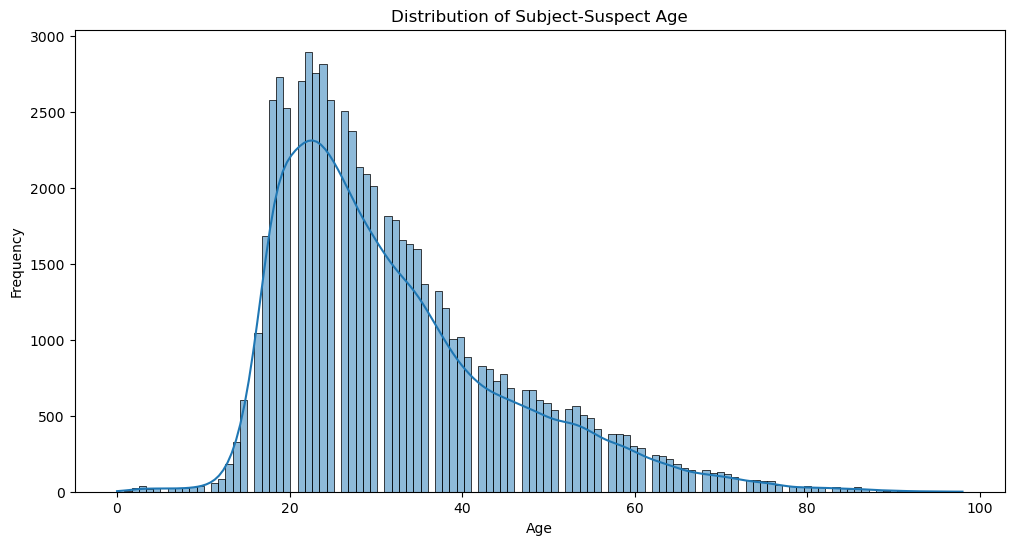

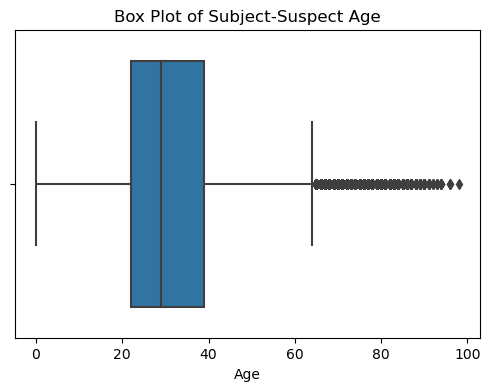

In [25]:
# Histogram and Density Plot
plt.figure(figsize=(12, 6))
sns.histplot(df['Subject-Suspect_age'], kde=True)
plt.title('Distribution of Subject-Suspect Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Subject-Suspect_age'])
plt.title('Box Plot of Subject-Suspect Age')
plt.xlabel('Age')
plt.show()

In [26]:
#columns_to_remove = df.columns[8:28]  # Python is 0-indexed
#df = df.drop(columns=columns_to_remove)
#df = df.drop(columns="incident_url")
#df = df.drop(columns="address")

In [27]:
#df.head()

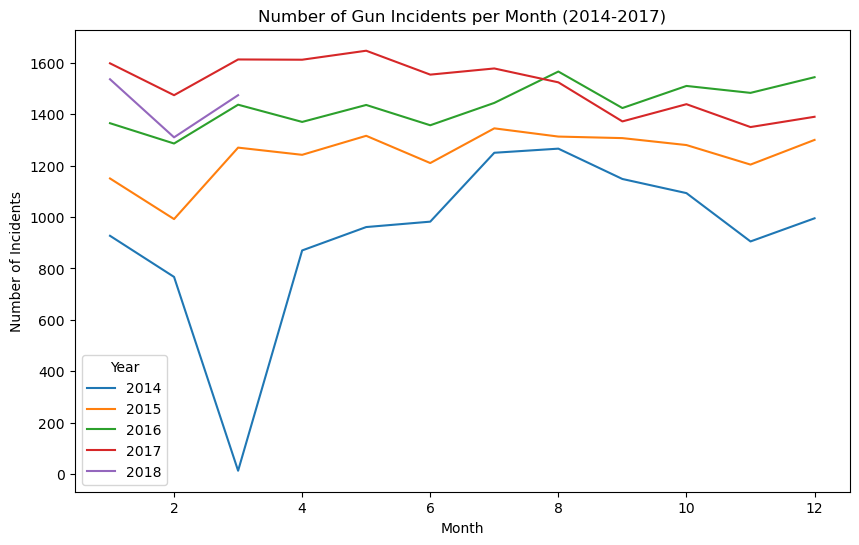

In [28]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
count = df.groupby(['year', 'month']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
for year in count['year'].unique():
    year_data = count[count['year'] == year]
    plt.plot(year_data['month'], year_data['count'], label=str(year))

plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Number of Gun Incidents per Month (2014-2017)')
plt.legend(title='Year')
plt.show()

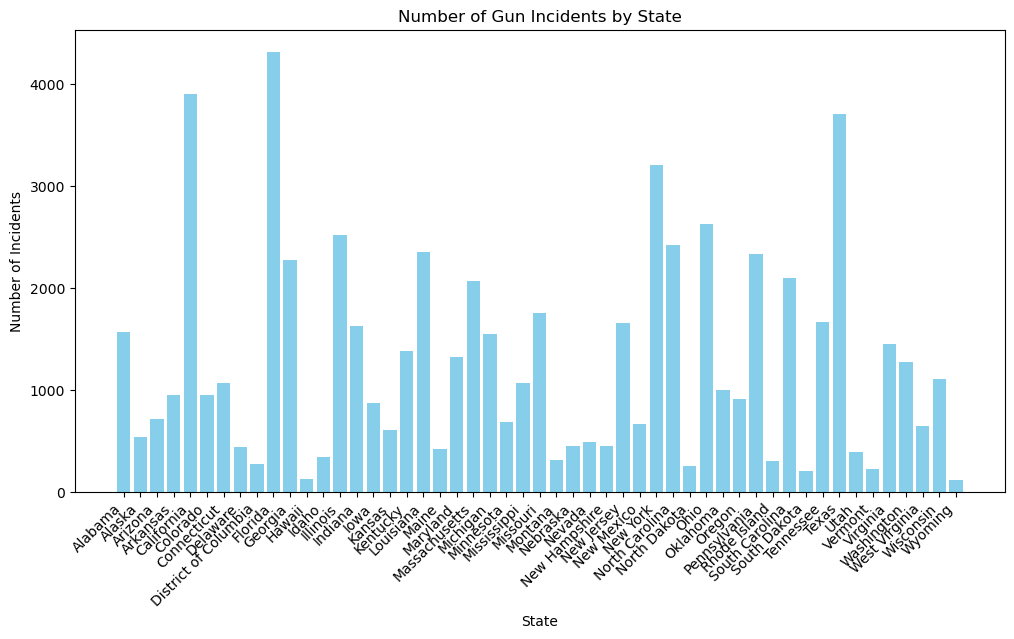

In [29]:
incident_count_by_state = df.groupby('state').size().reset_index(name='incident_count')
plt.figure(figsize=(12, 6))
plt.bar(incident_count_by_state['state'], incident_count_by_state['incident_count'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Incidents')
plt.title('Number of Gun Incidents by State')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [30]:
# Calculate the mean, minimum, and maximum for the specified columns
mean_values = df[['n_killed', 'n_injured']].mean()
min_values = df[['n_killed', 'n_injured']].min()
max_values = df[['n_killed', 'n_injured']].max()

# Display the results
print("Mean values:\n", mean_values)
print("\nMinimum values:\n", min_values)
print("\nMaximum values:\n", max_values)

Mean values:
 n_killed     0.347133
n_injured    0.318455
dtype: float64

Minimum values:
 n_killed     0
n_injured    0
dtype: int64

Maximum values:
 n_killed     50
n_injured    53
dtype: int64


In [31]:
# cleaning up the data
df.head()
df = df.drop(columns="incident_url")
df = df.drop(columns="address")
df = df.drop(columns="incident_url_fields_missing")
df = df.drop(columns="source_url")
df = df.drop(columns="sources")

In [32]:
# we need to remove the useless columns 

In [33]:
df.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1
286,92218,2014-01-01,Georgia,Bibb County,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,142.0,26.0,1,35.0,24.0,Male,30-40,1,2014,1
287,104905,2014-01-01,Virginia,Prince William County,0,1,1.0,NaN,NaN,Shot - Wounded/Injured,...,50.0,29.0,1,25.0,31.0,Male,20-30,1,2014,1
289,94154,2014-01-01,Virginia,Hampton,0,0,3.0,NaN,NaN,Armed robbery with injury/death and/or evidenc...,...,92.0,2.0,1,19.0,19.0,Male,10-20,1,2014,1


In [34]:
nan_counts = df.isna().sum()
total_nan_count = nan_counts.sum()
rows_with_nan = df[df.isna().any(axis=1)]
total_rows = len(df)

# Print the results
print(f'NaN counts for each column:\n{nan_counts}\n')
print(f'Total NaN count in the DataFrame: {total_nan_count}\n')
print(f'Number of rows with at least one NaN value: {len(rows_with_nan)}\n')
print(f'Total number of rows in the DataFrame: {total_rows}')

NaN counts for each column:
incident_id                          0
date                                 0
state                                0
city_or_county                       0
n_killed                             0
n_injured                            0
congressional_district            4138
gun_stolen                       19447
gun_type                         19436
incident_characteristics            57
latitude                          2999
location_description             54178
longitude                         2999
n_guns_involved                  19436
notes                            20694
participant_age                      0
participant_age_group               50
participant_gender                   0
participant_name                  5303
participant_relationship         57196
participant_status                 233
participant_type                     0
state_house_district             11634
state_senate_district             9706
arrested_count                      

In [35]:
df.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1
286,92218,2014-01-01,Georgia,Bibb County,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,142.0,26.0,1,35.0,24.0,Male,30-40,1,2014,1
287,104905,2014-01-01,Virginia,Prince William County,0,1,1.0,NaN,NaN,Shot - Wounded/Injured,...,50.0,29.0,1,25.0,31.0,Male,20-30,1,2014,1
289,94154,2014-01-01,Virginia,Hampton,0,0,3.0,NaN,NaN,Armed robbery with injury/death and/or evidenc...,...,92.0,2.0,1,19.0,19.0,Male,10-20,1,2014,1


In [36]:
column_name = 'congressional_district'
df = df.dropna(subset=[column_name.strip()])
df.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1
286,92218,2014-01-01,Georgia,Bibb County,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,142.0,26.0,1,35.0,24.0,Male,30-40,1,2014,1
287,104905,2014-01-01,Virginia,Prince William County,0,1,1.0,NaN,NaN,Shot - Wounded/Injured,...,50.0,29.0,1,25.0,31.0,Male,20-30,1,2014,1
289,94154,2014-01-01,Virginia,Hampton,0,0,3.0,NaN,NaN,Armed robbery with injury/death and/or evidenc...,...,92.0,2.0,1,19.0,19.0,Male,10-20,1,2014,1


In [37]:
df.head(2)

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1


# Begin implementing the model

In [49]:
display(df.head())
df.shape

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,...,state_house_district,state_senate_district,arrested_count,Subject-Suspect_age,Victim_average_age,Subject-Suspect_gender,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month
280,92383,2014-01-01,New York,Queens,1,0,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",...,33.0,14.0,1,26.0,22.0,Male,20-30,1,2014,1
283,92272,2014-01-01,Georgia,Columbus,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,135.0,15.0,1,25.0,27.0,Male,20-30,1,2014,1
286,92218,2014-01-01,Georgia,Bibb County,0,1,2.0,NaN,NaN,Shot - Wounded/Injured,...,142.0,26.0,1,35.0,24.0,Male,30-40,1,2014,1
287,104905,2014-01-01,Virginia,Prince William County,0,1,1.0,NaN,NaN,Shot - Wounded/Injured,...,50.0,29.0,1,25.0,31.0,Male,20-30,1,2014,1
289,94154,2014-01-01,Virginia,Hampton,0,0,3.0,NaN,NaN,Armed robbery with injury/death and/or evidenc...,...,92.0,2.0,1,19.0,19.0,Male,10-20,1,2014,1


(61661, 32)